In [2]:
!pip install onednn-cpu-gomp

Defaulting to user installation because normal site-packages is not writeable


In [3]:
TF_ENABLE_ONEDNN_OPTS = 0

In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

2024-01-15 04:23:49.305704: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-15 04:23:49.447254: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 04:23:50.089060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 04:23:50.089120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 04:23:50.238484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "CropDisease",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 25027 files belonging to 19 classes.


In [7]:
class_names = dataset.class_names
class_names

['BellPepper_BacterialSpot',
 'BellPepper_Healthy',
 'Maize_CercosporaLeafSpot',
 'Maize_CommonRust',
 'Maize_Healthy',
 'Maize_NorthernLeafBlight',
 'Potato_Early Blight',
 'Potato_Healthy',
 'Potato_LateBlight',
 'Rice_BrownSpot',
 'Rice_Healthy',
 'Rice_Hispa',
 'Rice_LeafBlast',
 'Tomato_BacterialSpot',
 'Tomato_EarlyBlight',
 'Tomato_Healthy',
 'Tomato_LateBlight',
 'Tomato_SeptoriaLeafSpot',
 'Tomato_YellowLeafCurlVirus']

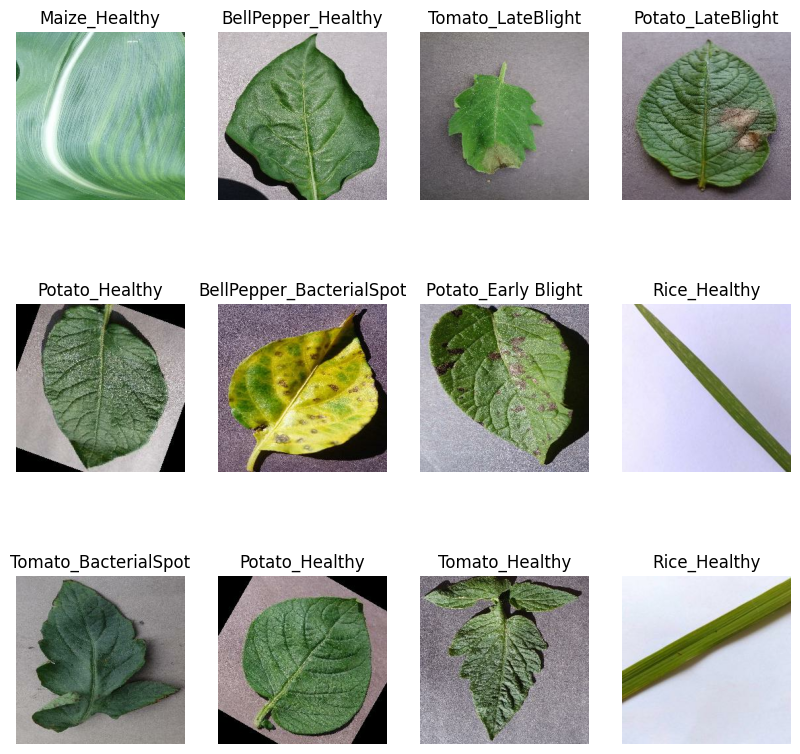

In [8]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

783

In [10]:
train_size = 0.8
len(dataset)*train_size

626.4000000000001

In [11]:
train_ds = dataset.take(112)
len(train_ds)

112

In [12]:
test_ds = dataset.skip(112)
len(test_ds)

671

In [13]:
val_size = 0.1
len(dataset) * val_size

78.30000000000001

In [14]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [15]:
test_ds = test_ds.skip(14)
len(test_ds)

657

In [16]:
def get_dataset_partitions_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    train_size=int(train_split*ds_size)

    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

626

In [19]:
len(val_ds)

78

In [20]:
len(test_ds)

79

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
n_classes = 20
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [27]:
history = model.fit(
        train_ds,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        verbose = 1,
        validation_data = val_ds
    )

Epoch 1/50
626/626 [==============================] - 41s 61ms/step - loss: 1.8880 - accuracy: 0.4019 - val_loss: 1.4537 - val_accuracy: 0.5152
Epoch 2/50
626/626 [==============================] - 36s 57ms/step - loss: 1.0207 - accuracy: 0.6499 - val_loss: 0.9632 - val_accuracy: 0.6999
Epoch 3/50
626/626 [==============================] - 34s 54ms/step - loss: 0.7573 - accuracy: 0.7322 - val_loss: 0.9297 - val_accuracy: 0.6951
Epoch 4/50
626/626 [==============================] - 34s 55ms/step - loss: 0.6379 - accuracy: 0.7729 - val_loss: 0.7254 - val_accuracy: 0.7512
Epoch 5/50
626/626 [==============================] - 34s 55ms/step - loss: 0.5638 - accuracy: 0.8014 - val_loss: 0.6413 - val_accuracy: 0.7837
Epoch 6/50
626/626 [==============================] - 34s 54ms/step - loss: 0.5305 - accuracy: 0.8084 - val_loss: 0.5569 - val_accuracy: 0.8021
Epoch 7/50
626/626 [==============================] - 34s 55ms/step - loss: 0.4929 - accuracy: 0.8218 - val_loss: 0.7771 - val_accuracy:

In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 73ms/step


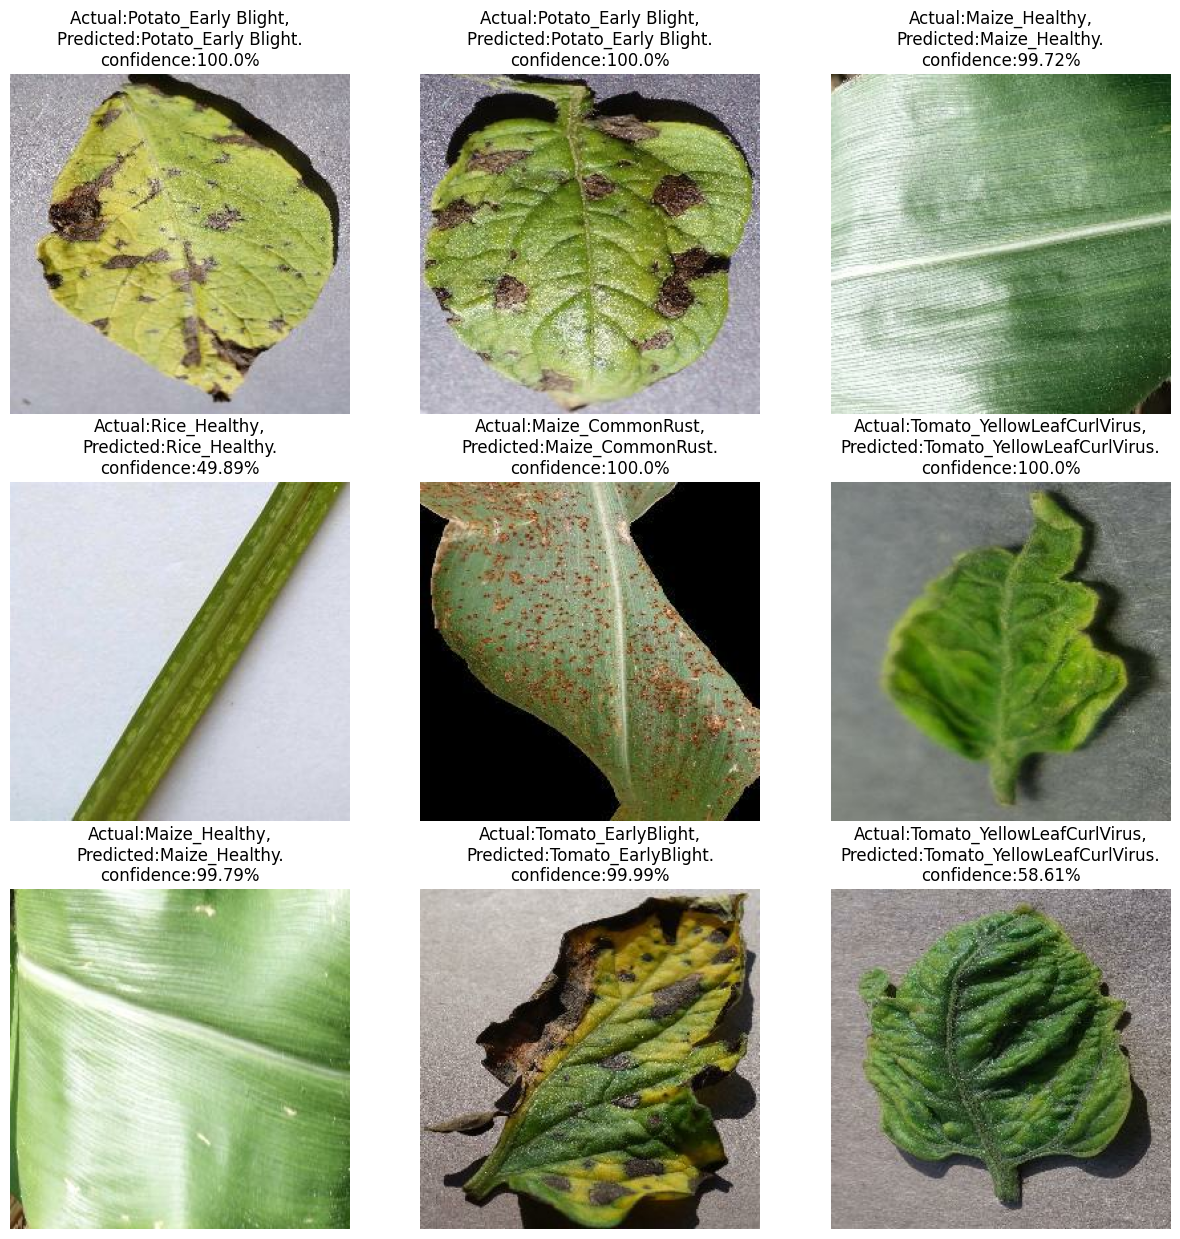

In [30]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\nPredicted:{predicted_class}.\nconfidence:{confidence}%")
        plt.axis("off")


In [31]:
model.save("CD3.h5")

/home/ud0f413336ada908565cd1c5932c72ea/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
from PIL import Image
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import models,layers
import numpy as np

In [33]:
def loading(image_path):
    def image_path_to_np_array(image_path):
        try:
            # Read the image using PIL
            image = Image.open(image_path)

            # Convert the image to a NumPy array
            image_array = np.array(image)

            # If the image has an alpha channel, remove it
            if image_array.shape[-1] == 4:
                image_array = image_array[:, :, :3]
            return image_array

        except Exception as e:
            print(f"Error: {e}")
            return None
    
    model_path = 'CD3.h5'
    loaded_model = tf.keras.models.load_model(model_path)
    img_array=tf.keras.preprocessing.image.img_to_array(image_path_to_np_array(image_path))
    img_array=tf.expand_dims(img_array,0)
    

    # Make a prediction using the loaded model
    predictions = loaded_model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

In [34]:
image_path="CropDisease/Tomato_YellowLeafCurlVirus/06718520-1ddc-40e0-ada1-37910bc41e36___UF.GRC_YLCV_Lab 01534.JPG"

In [35]:
loading(image_path)

1/1 [==============================] - 0s 229ms/step


('Tomato_YellowLeafCurlVirus', 96.03)

In [36]:
image_path="CropDisease/BellPepper_BacterialSpot/055a84c4-8286-4b44-816a-66b82d3bd4bc___NREC_B.Spot 9105_180deg.JPG"

In [37]:
loading(image_path)

1/1 [==============================] - 0s 236ms/step


('BellPepper_BacterialSpot', 99.83)